# Graph Neural Network

Author: Adam Darmanin & Christian Spiteri Gauci

## Tensorflow GCN Citation

```latex
@article{tfgnn,
  author  = {Oleksandr Ferludin and Arno Eigenwillig and Martin Blais and
             Dustin Zelle and Jan Pfeifer and Alvaro Sanchez{-}Gonzalez and
             Wai Lok Sibon Li and Sami Abu{-}El{-}Haija and Peter Battaglia and
             Neslihan Bulut and Jonathan Halcrow and
             Filipe Miguel Gon{\c{c}}alves de Almeida and Pedro Gonnet and
             Liangze Jiang and Parth Kothari and Silvio Lattanzi and 
             Andr{\'{e}} Linhares and Brandon Mayer and Vahab Mirrokni and
             John Palowitch and Mihir Paradkar and Jennifer She and
             Anton Tsitsulin and Kevin Villela and Lisa Wang and David Wong and
             Bryan Perozzi},
  title   = {{TF-GNN:} Graph Neural Networks in TensorFlow},
  journal = {CoRR},
  volume  = {abs/2207.03522},
  year    = {2023},
  url     = {http://arxiv.org/abs/2207.03522},
}

@misc{StellarGraph,
  author = {CSIRO's Data61},
  title = {StellarGraph Machine Learning Library},
  year = {2018},
  publisher = {GitHub},
  journal = {GitHub Repository},
  howpublished = {\url{https://github.com/stellargraph/stellargraph}},
}
```

## Supervised graph classification Problem

Posts are graphs, and graphs are within a mental health category.
We need to classify the graph.

- paper: https://arxiv.org/abs/1902.06673
- see: https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html#Edge-features
- see: https://stellargraph.readthedocs.io/en/stable/demos/graph-classification/

GNNS take graphs as inputs, and perform trained transformations and aggregations of features across the nodes and edges.
GNNs maintain vectors for each node - the node state, similar to a neuron.

The GNN updates the states with trainable functions: message passing, convolutions or attention. An update is
1. States are broadcas across edges.
2. Message is computed as an aggregate function.
3. Nodes pool messages using a fucntion or attention model.
4. Each node updates the state - using a NN possible.
5. Process is repeated.
6. Hetero graphs get seperate wieghts. Irregular and not possible with a normal tensor (similar to NLP) and needs a graph tensor (ragged tensor), this also store direction.
7. Trained e2e by BP to reduct loss.
8. Reading out the final GNN  state

Arch:
- Encoder for input features
- GNN for state update
- A prediction head
- Node sets - feature containers + size info, -1 being latent and ragged. All nodes in a set (id) have same features.
- lantent nodes - nodes with out features whose embeddings will be calc.
- Edge Sets (source and target), ead set also has adjancy object.
- homo graphs - edge sets on single type of node (both source and target)
- Context or Global features. The ground truth for the whole graph or sub-graph.

In training, a seed node or sub-graph is required. Graph classification, take tensor with hidden states and apply a classifier on top, this is for an inplicit readout for a sinlge node of interest, or direct readout for a feture tensor. Can aklso have a special node for structre readouts.

# Graph Schema

- see: tensorflow_gnn/proto/graph_schema.proto:GraphSchema
- see schema: ./gnn/mh_gnn.pbtxt

- Validate schema: `tfgnn_validate_graph_schema --logtostderr --graph_schema=gnn/mh_graph.pbtxt`
- Generatete mock training data: `tfgnn_generate_training_data --graph_schema=gnn/mh_graph.pbtxt --examples=gnn/mh_graph.tfrecord --file_format=tfrecord --num_examples=100`

#### Getting 6 dataframes from the graph using queries. Fix LIMIT size to change reach

In [73]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from random import random

uri = "bolt://localhost:7687"
client_id = os.getenv("N4J_USER")
client_secret = os.getenv("N4J_PW")

def convert_to_list(value):
    if isinstance(value, np.ndarray):
        return value.tolist()
    return value

def fetch_mental_health_disorder_data(session):
    mental_health_disorder_dataframes = {}

    # This query was tested on Neo4j and it worked
    mental_health_disorders_query = "MATCH (m:Mental_Health_Disorder) RETURN m"

    mental_health_disorders_result = session.run(mental_health_disorders_query)

    for mental_health_disorder_record in tqdm(mental_health_disorders_result, desc="Processing Mental Health Disorders", unit="node"):
        mental_health_disorder_node = mental_health_disorder_record["m"]
        

        disorder_name = mental_health_disorder_node.get("name")
        print(f"Mental Health Disorder Name: {disorder_name}")

        relationships_query = "MATCH path=(m:Mental_Health_Disorder)-[r*1..5]-(n) WHERE ID(m) = $mental_health_disorder_node_id RETURN path LIMIT 1000" #Change Limit number to any number. Can remove for whole graph
        relationships_result = session.run(relationships_query, {"mental_health_disorder_node_id": mental_health_disorder_node.id})

        relationships_data = []
        for rel_record in relationships_result:
            path = rel_record["path"]
            nodes = path.nodes

            for i in range(len(nodes) - 1):
                source_node = nodes[i]
                target_node = nodes[i + 1]
                relationship_type = path.relationships[i].type

                # relationships_data.append(
                #     {
                #         "source_embedding": convert_to_list(source_node.get("embedding")),
                #         "relationship": relationship_type,
                #         "target_embedding": convert_to_list(target_node.get("embedding")),
                #     }
                # )

                relationships_data.append(
                       {
                            "source_node_name": source_node.get("name"),
                            "source_embedding": convert_to_list(source_node.get("embedding")),
                            "relationship": relationship_type,
                            "target_node_name": target_node.get("name"),
                            "target_embedding": convert_to_list(target_node.get("embedding")),
                        }
                )

        print(f"Length of relationships_data: {len(relationships_data)}")

        df_name = f"df_{disorder_name.replace(' ', '_')}"
        mental_health_disorder_dataframes[df_name] = pd.DataFrame(relationships_data)
        print(f"Created DataFrame: {df_name}")

    return mental_health_disorder_dataframes

with GraphDatabase.driver(uri, auth=(client_id, client_secret)) as driver:
    with driver.session() as session:
        mental_health_disorder_dataframes = fetch_mental_health_disorder_data(session)




Processing Mental Health Disorders: 0node [00:00, ?node/s]C:\Users\chris\AppData\Local\Temp\ipykernel_29656\593375664.py:31: DeprecationWarning: `id` is deprecated, use `element_id` instead
  relationships_result = session.run(relationships_query, {"mental_health_disorder_node_id": mental_health_disorder_node.id})


Mental Health Disorder Name: anxiety


Processing Mental Health Disorders: 1node [00:00,  1.05node/s]

Length of relationships_data: 4988
Created DataFrame: df_anxiety
Mental Health Disorder Name: bpd


Processing Mental Health Disorders: 2node [00:01,  1.14node/s]

Length of relationships_data: 4987
Created DataFrame: df_bpd
Mental Health Disorder Name: depression


Processing Mental Health Disorders: 3node [00:02,  1.28node/s]

Length of relationships_data: 4983
Created DataFrame: df_depression
Mental Health Disorder Name: schizophrenia


Processing Mental Health Disorders: 4node [00:03,  1.30node/s]

Length of relationships_data: 4984
Created DataFrame: df_schizophrenia
Mental Health Disorder Name: mentalillness


Processing Mental Health Disorders: 5node [00:03,  1.33node/s]

Length of relationships_data: 4985
Created DataFrame: df_mentalillness
Mental Health Disorder Name: bipolar


Processing Mental Health Disorders: 6node [00:04,  1.27node/s]

Length of relationships_data: 4989
Created DataFrame: df_bipolar


In [74]:
print(mental_health_disorder_dataframes["df_anxiety"])

     source_node_name                                   source_embedding  \
0             anxiety  [-0.05983474850654602, 0.036320917308330536, 0...   
1             anxiety  [-0.05983474850654602, 0.036320917308330536, 0...   
2              thrown  [-0.021872837096452713, -0.0012634199811145663...   
3             anxiety  [-0.05983474850654602, 0.036320917308330536, 0...   
4              thrown  [-0.021872837096452713, -0.0012634199811145663...   
...               ...                                                ...   
4983          anxiety  [-0.05983474850654602, 0.036320917308330536, 0...   
4984           thrown  [-0.021872837096452713, -0.0012634199811145663...   
4985            trash  [-0.05023549497127533, 0.028847483918070793, 0...   
4986            clean  [-0.011358335614204407, 0.063572458922863, 0.0...   
4987             feel  [0.02099844440817833, -0.005194579251110554, 0...   

     relationship target_node_name  \
0            dobj           thrown   
1          

Keeping the words as Nodes, and then creating a df with the embedding as a feature of those words to be able to feed to GCN

In [75]:
from stellargraph import StellarGraph
import pandas as pd
import numpy as np

stellar_graphs = []
labels = []

for df_name, df in mental_health_disorder_dataframes.items():
    print("Processing DataFrame:", df_name)
    
    df = mental_health_disorder_dataframes[df_name].drop('relationship', axis=1) 

    valid_rows = ~df['source_embedding'].isna() & ~df['target_embedding'].isna()
    df = df[valid_rows]


    unique_words = list(set(df['source_node_name']).union(set(df['target_node_name'])))
    nodes_data_df = pd.DataFrame(index=unique_words)
    nodes_data_df['embedding'] = [list() for _ in nodes_data_df.index]


    for _, row in df.iterrows():
        source_embedding = row['source_embedding']
        target_embedding = row['target_embedding']
        nodes_data_df.at[row['source_node_name'], 'embedding'].extend(source_embedding)
        nodes_data_df.at[row['target_node_name'], 'embedding'].extend(target_embedding)

    
    nodes_data_df['embedding'] = nodes_data_df['embedding'].apply(lambda x: hash(tuple(x)))


    source_nodes = pd.Series(df['source_node_name'].rename('source'))
    target_nodes = pd.Series(df['target_node_name'].rename('target'))

    df = pd.concat([source_nodes, target_nodes], axis=1)

    # testGraph = StellarGraph(edges=df)
    testGraph = StellarGraph(nodes_data_df, df)


    label = df_name.replace('df_', '')
    print("Extracted Label:", label)

    stellar_graphs.append(testGraph)
    labels.append(label)


    

print(stellar_graphs[0].info())
print(labels[0])

graph_df = pd.DataFrame({"Graph": stellar_graphs, "Label": list(labels)})
graph_df.head(3)



Processing DataFrame: df_anxiety
Extracted Label: anxiety
Processing DataFrame: df_bpd
Extracted Label: bpd
Processing DataFrame: df_depression
Extracted Label: depression
Processing DataFrame: df_schizophrenia
Extracted Label: schizophrenia
Processing DataFrame: df_mentalillness
Extracted Label: mentalillness
Processing DataFrame: df_bipolar
Extracted Label: bipolar
StellarGraph: Undirected multigraph
 Nodes: 695, Edges: 4805

 Node types:
  default: [695]
    Features: float32 vector, length 1
    Edge types: default-default->default

 Edge types:
    default-default->default: [4805]
        Weights: all 1 (default)
        Features: none
anxiety


,Graph,Label
0,<stellargraph.core.graph.StellarGraph object a...,anxiety
1,<stellargraph.core.graph.StellarGraph object a...,bpd
2,<stellargraph.core.graph.StellarGraph object a...,depression


In [77]:
from stellargraph import StellarGraph
from stellargraph.data import BiasedRandomWalk
from sklearn.cluster import SpectralClustering
import networkx as nx


segmented_subgraphs = []

for i, graph in enumerate(stellar_graphs):
    print("Segmenting Graph:", i)

    # Generate biased random walks on the graph
    rw = BiasedRandomWalk(graph)
    walks = rw.run(graph.nodes(), n=10, length=80, p=0.5, q=2.0)

    # Map node names to numeric indices
    node_mapping = {node: idx for idx, node in enumerate(graph.nodes())}
    walks_numeric = [[node_mapping[node] for node in walk] for walk in walks]

    # Apply clustering algorithm (e.g., Spectral Clustering)
    clustering = SpectralClustering(n_clusters=10, assign_labels="discretize", random_state=42)
    node_labels = clustering.fit_predict(walks_numeric)

    subgraphs = []
    for label in set(node_labels):
        nodes_in_cluster = [node for node, cluster_label in zip(graph.nodes(), node_labels) if cluster_label == label]
        subgraph = graph.subgraph(nodes_in_cluster)
        
        if len(subgraph.nodes()) > 0:
            subgraphs.append(subgraph)

    segmented_subgraphs.extend(subgraphs)



Segmenting Graph: 0


c:\Users\chris\anaconda3\envs\GNN\lib\site-packages\sklearn\manifold\_spectral_embedding.py:285: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Segmenting Graph: 1


c:\Users\chris\anaconda3\envs\GNN\lib\site-packages\sklearn\manifold\_spectral_embedding.py:285: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Segmenting Graph: 2


c:\Users\chris\anaconda3\envs\GNN\lib\site-packages\sklearn\manifold\_spectral_embedding.py:285: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Segmenting Graph: 3


# GCN Architecture

![alt](./misc/gcn_arch.PNG)

Generator feeds data to the NN.

- 2 convolutional layers (64-dimensional output features map in each) 
- 2 fully connected layers (producing 32-and 2-dimensional output features, respectively) to predict the mental health or lack off class probabilities. 
- 1 head of graph attention was used in every convolutional layer to implement the filters together with mean-pooling for dimensionality reduction.
- We used Scaled Exponential Linear Unit (SELU) as non-linearity throughout the entire network.
- Hinge loss was employed to train the neural network (we preferred hinge loss to the more commonly
- used mean cross entropy as it outperformed the latter in early experiments). No regularization was
used with our model

In [72]:
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCNSupervisedGraphClassification
from stellargraph.layer import GraphAttention, MeanPoolingAggregator
from IPython.display import display, HTML

from tensorflow.keras import Model
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt

generator = PaddedGraphGenerator(graphs=segmented_subgraphs)

from tensorflow.keras.losses import categorical_hinge


def create_graph_classification_model(generator):
    gc_model = GCNSupervisedGraphClassification(
        layer_sizes=[64, 64],
        activations=["selu", "selu"],
        generator=generator,
        dropout=0.5,
        pooling=None,
    )
    x_inp, x_out = gc_model.in_out_tensors()
    predictions = Dense(units=32, activation="selu")(x_out)
    predictions = Dense(units=6, activation="softmax")(predictions)

    model = Model(inputs=x_inp, outputs=predictions)
    model.compile(
        optimizer=Adam(0.005),
        loss=categorical_hinge,  # Use categorical hinge loss
        metrics=[categorical_accuracy],
    )

    return model


epochs = 25  # maximum number of training epochs
folds = 10  # the number of folds for k-fold cross validation
n_repeats = 2  # the number of repeats for repeated k-fold cross validation
es = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=25, restore_best_weights=True
)


def train_fold(model, train_gen, test_gen, es, epochs):
    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=test_gen,
        verbose=0,
        callbacks=[es],
    )
    test_metrics = model.evaluate(test_gen, verbose=0)
    test_acc = test_metrics[model.metrics_names.index("categorical_accuracy")]

    return history, test_acc


def get_generators(train_index, test_index, graph_labels, batch_size):
    train_targets = graph_labels.iloc[train_index].values
    test_targets = graph_labels.iloc[test_index].values
    train_targets = to_categorical(train_targets, num_classes=6)
    test_targets = to_categorical(test_targets, num_classes=6)
    train_gen = generator.flow(
        train_index,
        targets=train_targets,
        batch_size=batch_size,
    )
    test_gen = generator.flow(test_index, targets=test_targets, batch_size=batch_size)

    return train_gen, test_gen


test_accs = []

from sklearn.model_selection import StratifiedKFold

stratified_kfold = StratifiedKFold(n_splits=folds, shuffle=True)

for i, (train_index, test_index) in enumerate(
    stratified_kfold.split(
        graph_df,
        graph_df["Label"],
    )
):
    print(f"Training and evaluating on fold {i+1} out of {folds}...")
    train_gen, test_gen = get_generators(
        train_index, test_index, graph_df["Label"], batch_size=30
    )

    model = create_graph_classification_model(generator)
    assert model is not None

    history, acc = train_fold(model, train_gen, test_gen, es, epochs)

    test_accs.append(acc)

print(
    f"Accuracy over all folds mean: {np.mean(test_accs)*100:.3f}% and std: {np.std(test_accs)*100:.2f}%"
)

ValueError: graphs: expected every graph to be non-empty, found graph with no nodes

Text(0, 0.5, 'Count')

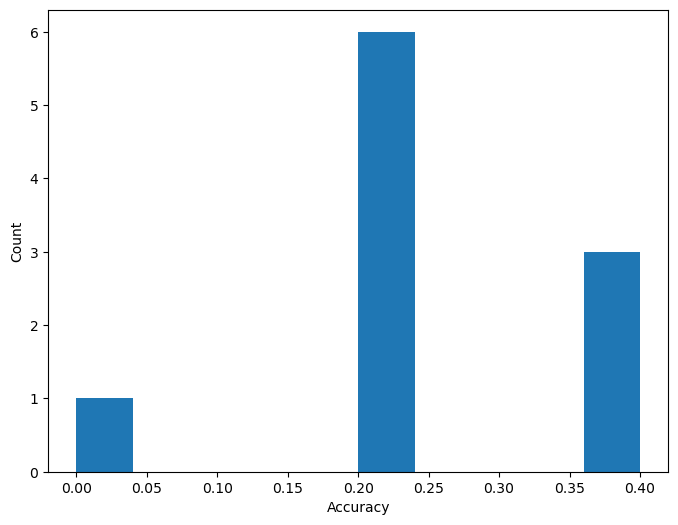

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(test_accs)
plt.xlabel("Accuracy")
plt.ylabel("Count")